In [35]:
import torch
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from torchaudio.datasets import SPEECHCOMMANDS

import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd



from utils.visualize_utils import log_specgram

### Dataset description -- SpeechCommands V2
reference
- https://ai.googleblog.com/2017/08/launching-speech-commands-dataset.html
- https://huggingface.co/datasets/speech_commands

=> The dataset has 105,829 one-second long utterances of 30 short words
 

In [36]:
# download dataset
_ = SPEECHCOMMANDS("./data", download=True)

In [37]:
# dataset structure
# waveform, sample_rate, label, speaker_id, utterance_number
train_ds = SPEECHCOMMANDS("./data", subset="training")
test_ds = SPEECHCOMMANDS("./data", subset="testing")
val_ds = SPEECHCOMMANDS("./data", subset="validation")

### Data + Label exploration

In [38]:
# filename = 'data/SpeechCommands/speech_commands_v0.02/forward/0a2b400e_nohash_1.wav'
filename = 'data/SpeechCommands/speech_commands_v0.02/down/0a9f9af7_nohash_1.wav'
# file_name = 'data/SpeechCommands/speech_commands_v0.02/down/0b77ee66_nohash_1.wav'
# file_name = 'data/SpeechCommands/speech_commands_v0.02/cat/0ac15fe9_nohash_0.wav'
sample_rate, samples = wavfile.read(filename)
freqs, times, spectrogram = log_specgram(samples, sample_rate)
samples.shape
print(samples.shape, sample_rate)

(15702,) 16000


Text(0.5, 0, 'Seconds')

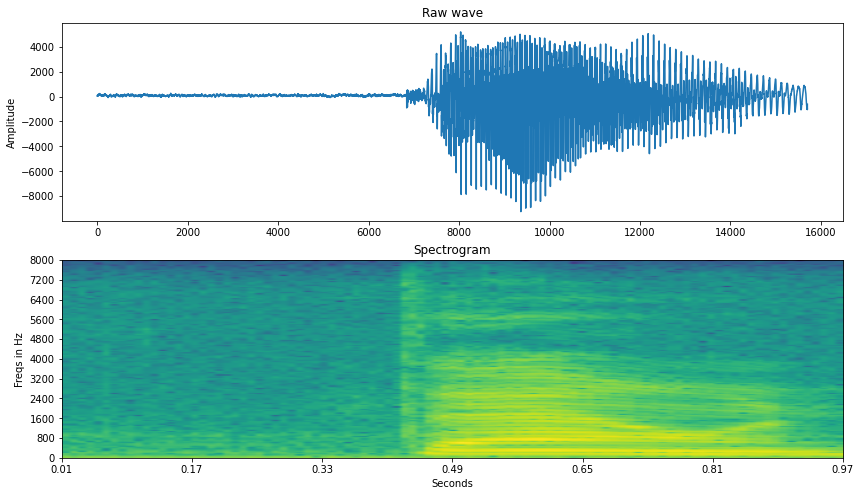

In [39]:
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave')
ax1.set_ylabel('Amplitude')
ax1.plot(samples)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram')
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')
